# Evaluation of text similarity metrics using GLUE tasks

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        model_name = 'WillHeld/roberta-base-stsb'
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5
    
class SBERTCosine:
    def __init__(self):
        model_name = 'sentence-transformers/all-MiniLM-L6-v2'
        self._sbert_model = SentenceTransformer(model_name)
        self._sbert_model.eval()

    def score(self, sentence1, sentence2):
        embeddings = self._sbert_model.encode([sentence1, sentence2])
        return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

bertscorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
sts_scorer = STSScorer()
sbertcosine = SBERTCosine()

def fetch_scores(data, feature1, feature2):
    print(len(data))
    scores = []
    count = 0
    
    # check if data is pd.DataFrame
    if isinstance(data, pd.DataFrame):
        for index, row in data.iterrows():
            #bert_score = bertscorer.score([row[feature1]], [row[feature2]], verbose=False)
            #bleu_score = bleu.compute(predictions=[row[feature1]], references=[row[feature2]])['bleu']
            #stsb_score = sts_scorer.score(row[feature1], row[feature2])
            #sbert_score = sbertcosine.score(row[feature1], row[feature2])
            scores.append(score_instance(row, feature1, feature2))
            count += 1
            if count % 1000 == 0:
                print(count)
            if count > 100:
                #break
                pass
    else:    
        for instance in data:
            #bert_score = bertscorer.score([instance[feature1]], [instance[feature2]], verbose=False)
            #bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
            #stsb_score = sts_scorer.score(instance[feature1], instance[feature2])
            #sbert_score = sbertcosine.score(instance[feature1], instance[feature2])
            scores.append(score_instance(instance, feature1, feature2))
            count += 1
            if count % 1000 == 0:
                print(count)
            if count > 100:
                #break
                pass
    return scores

def score_instance(instance, feature1, feature2):
    bert_score = bertscorer.score([instance[feature1]], [instance[feature2]], verbose=False)
    bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
    stsb_score = sts_scorer.score(instance[feature1], instance[feature2])
    sbert_score = sbertcosine.score(instance[feature1], instance[feature2])
    return {'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'sts_score': stsb_score, 'sbertcosine': sbert_score}

/home/sherbold/git/stsscore/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## STS-B

In [8]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_stsb = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))

scores_stsb.to_csv('scores/stsb.csv')

Found cached dataset stsb_multi_mt (/home/sherbold/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


1379
1000


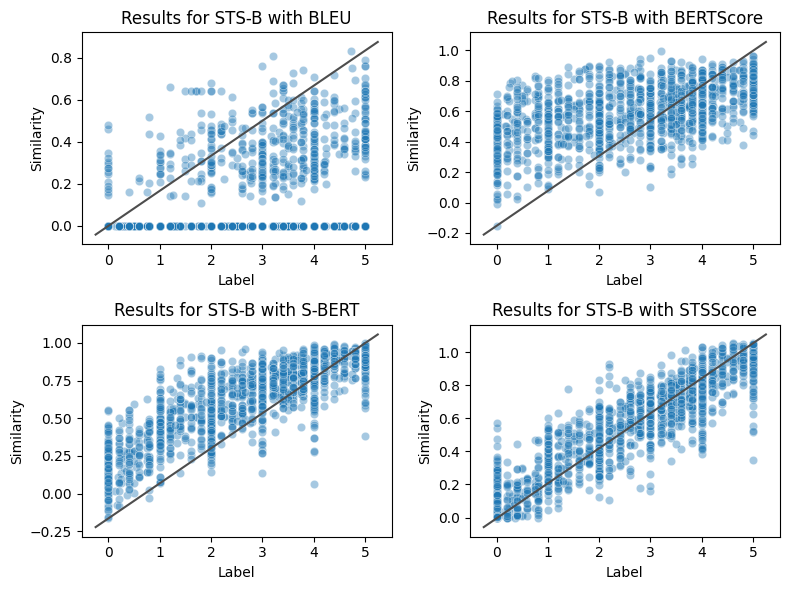

Pearson correlation


bleu            0.337758
bertscore_f1    0.528701
sts_score       0.895954
sbertcosine     0.827406
Name: label, dtype: float64

Spearman correlation


bleu            0.322598
bertscore_f1    0.527128
sts_score       0.889744
sbertcosine     0.820325
Name: label, dtype: float64

In [20]:
scores_stsb = pd.read_csv('scores/stsb.csv')

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.scatterplot(x="label", y="bleu", data=scores_stsb, alpha=0.4, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_stsb, alpha=0.4, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])

## MRPC

In [11]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))
scores_mrpc.to_csv('scores/mrpc.csv')

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 535.79it/s]


1725
1000


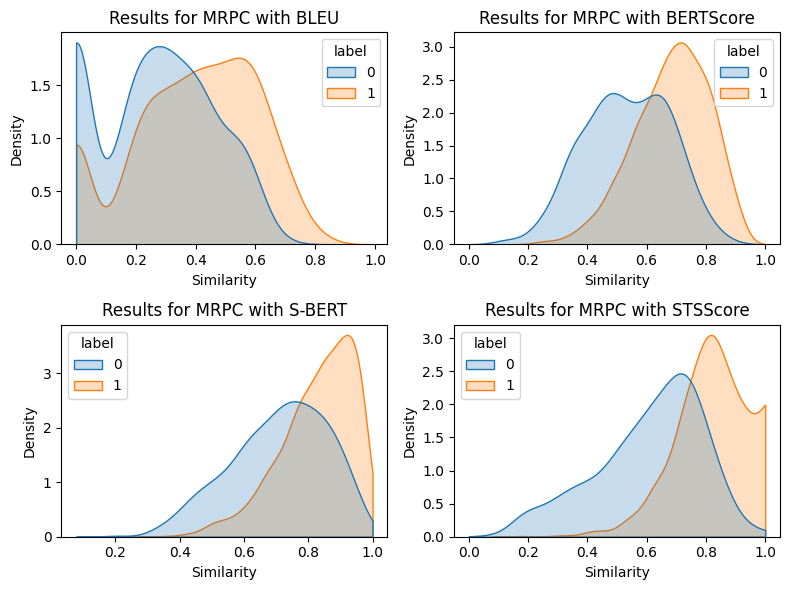

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,887.468858,0.535354,0.530234,0.532616,0.260324,0.610237,0.709273
1,849.165650,0.684321,0.682521,0.683187,0.392253,0.837354,0.827843


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,505.174105,0.159769,0.164882,0.145341,0.191747,0.180009,0.149024
1,494.234810,0.142888,0.139676,0.125755,0.209861,0.134796,0.115480


In [2]:
scores_mrpc = pd.read_csv('scores/mrpc.csv')
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(scores_mrpc, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_mrpc, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for MRPC with BLEU")
axes[0,1].set_title("Results for MRPC with BERTScore")
axes[1,0].set_title("Results for MRPC with S-BERT")
axes[1,1].set_title("Results for MRPC with STSScore")

sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())

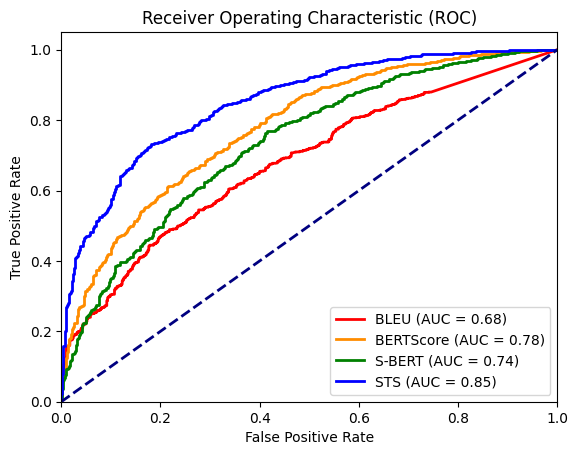

In [8]:
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_mrpc['label'], scores_mrpc['bertscore_f1'])
fpr_bleu, tpr_bleu, thresholds_bleu = roc_curve(scores_mrpc['label'], scores_mrpc['bleu'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_mrpc['label'], scores_mrpc['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_mrpc['label'], scores_mrpc['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_bleu = auc(fpr_bleu, tpr_bleu)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_bleu, tpr_bleu, color='red', lw=2, label='BLEU (AUC = %0.2f)' % roc_auc_bleu)
plt.plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
plt.plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
plt.plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## QQP

In [2]:
data = load_dataset('glue', 'qqp')['train']
scores_qqp = pd.DataFrame(fetch_scores(data, 'question1', 'question2'))
scores_qqp.to_csv('scores/qqp.csv')

363846
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
15

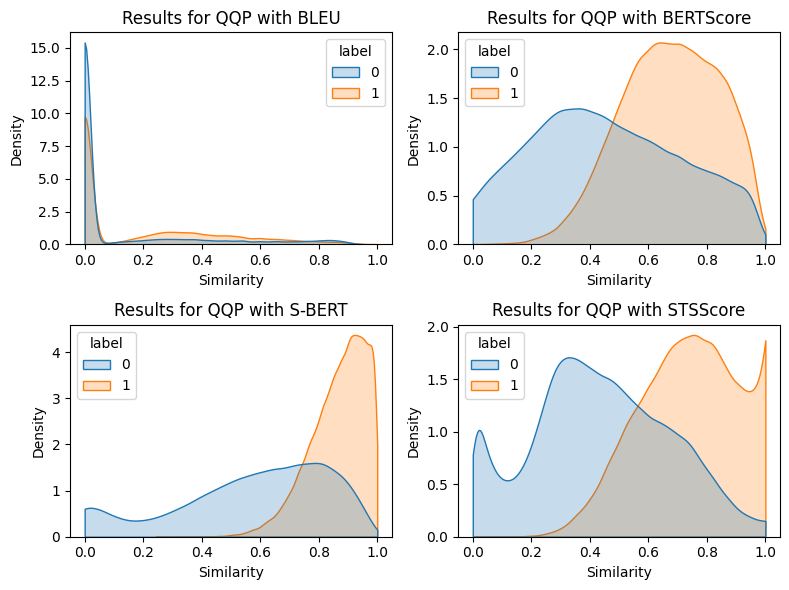

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,182006.746963,0.438191,0.444688,0.441274,0.113036,0.439641,0.560253
1,181778.637299,0.673945,0.673659,0.673431,0.184540,0.762966,0.864571


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,105000.718917,0.275215,0.275584,0.264823,0.232932,0.236197,0.271149
1,105089.519470,0.180303,0.180175,0.166039,0.249377,0.181817,0.095797


In [6]:
scores_qqp = pd.read_csv('scores/qqp.csv')
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(scores_qqp, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_qqp, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for QQP with BLEU")
axes[0,1].set_title("Results for QQP with BERTScore")
axes[1,0].set_title("Results for QQP with S-BERT")
axes[1,1].set_title("Results for QQP with STSScore")

sns.move_legend(axes[0,1], "upper left")
sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_qqp.groupby('label').mean())
print('Standard deviation')
display(scores_qqp.groupby('label').std())

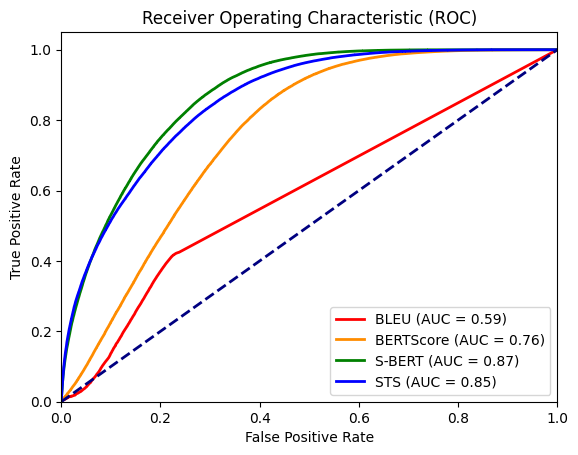

In [9]:
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_qqp['label'], scores_qqp['bertscore_f1'])
fpr_bleu, tpr_bleu, thresholds_bleu = roc_curve(scores_qqp['label'], scores_qqp['bleu'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_qqp['label'], scores_qqp['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_qqp['label'], scores_qqp['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_bleu = auc(fpr_bleu, tpr_bleu)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_bleu, tpr_bleu, color='red', lw=2, label='BLEU (AUC = %0.2f)' % roc_auc_bleu)
plt.plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
plt.plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
plt.plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [40]:
#langs = ['cs-en', 'de-en', 'liv-en', 'ru-en', 'uk-en', 'zh-en']
#best_refs = ['refB', 'refA', 'refA', 'refA', 'refA', 'refA']
#human_ratings = ['wmt', 'wmt', 'wmt-appraise', 'wmt', 'wmt', 'mqm']

langs = ['zh-en']
best_refs = ['refA']
human_ratings = ['mqm']

all_scores = None
for lang, best_ref, human_rating in zip(langs, best_refs, human_ratings):
    with open('data/wmt22/sources/%s.txt' % lang) as f:
        sources = f.read().splitlines()
    with open('data/wmt22/references/%s.%s.txt' % (lang, best_ref)) as f:
        references = f.read().splitlines()

    human_scores = pd.read_csv('data/wmt22/human-scores/%s.%s.seg.score' % (lang, human_rating), sep='\t', header=None, names=['system', 'score'])

    folder_path = 'data/wmt22/system-outputs/'+lang
    for file in human_scores['system'].unique():
        with open(folder_path+'/'+file+'.txt') as f:
            translations = f.read().splitlines()
        human_scores.loc[human_scores['system'] == file, 'source'] = sources
        human_scores.loc[human_scores['system'] == file, 'reference'] = references
        human_scores.loc[human_scores['system'] == file, 'translation'] = translations
    human_scores['lang-pair'] = lang
    human_scores['system']
    if all_scores is None:
        all_scores = human_scores
    else:
        all_scores = pd.concat([all_scores, human_scores])

wmt22_df = all_scores.dropna()
wmt22_df = wmt22_df.rename(columns={'score': 'label'})
wmt22_df.to_csv('data/wmt22/wmt22.csv')
# read once to avoid issue with nan appearing later
wmt22_df = pd.read_csv('data/wmt22/wmt22.csv')
wmt22_df.dropna(inplace=True)
wmt22_df.to_csv('data/wmt22/wmt22.csv')

In [2]:
wmt22_df = pd.read_csv('data/wmt22/wmt22.csv')
scores_wmt22 = pd.DataFrame(fetch_scores(wmt22_df, 'reference', 'translation'))
scores_wmt22.to_csv('scores/wmt22.csv')

29999
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [33]:
scores_wmt22 = pd.read_csv('scores/wmt22.csv')
scores_wmt22['reference'] = wmt22_df['reference']
scores_wmt22['translation'] = wmt22_df['translation']
scores_wmt22['lang-pair'] = wmt22_df['lang-pair']
scores_wmt22['label2'] = wmt22_df['label']
scores_wmt22['system'] = wmt22_df['system']
scores_wmt22

,Unnamed: 0,label,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine,reference,translation,lang-pair,label2,system
0,0,0.754923,0.921465,0.921470,0.921595,0.581431,1.047111,0.988225,The big comeback of the Czech underdog is coming.,A big comeback for the Czech underdog is coming.,cs-en,80.0,CUNI-DocTransformer
1,1,-0.235501,1.000000,1.000000,1.000000,1.000000,1.042579,1.000000,Pavel Francouz has been called up to the NHL,Pavel Francouz has been called up to the NHL,cs-en,65.0,CUNI-DocTransformer
2,2,0.160669,0.857478,0.802137,0.829951,0.427505,1.033504,0.937152,"Czech hockey goal-keeper Pavel Francouz, who h...","Czech ice hockey goaltender Pavel Francouz, wh...",cs-en,71.0,CUNI-DocTransformer
3,3,0.160669,0.665640,0.835712,0.749814,0.692119,0.671362,0.730386,The thirty-one-year-old Pilsen native will be ...,The 31-year-old fullback will be on the bench ...,cs-en,71.0,CUNI-DocTransformer
4,4,-0.169473,0.741622,0.673544,0.707852,0.559626,0.951098,0.879963,"The former goalie of Litvínov, Pilsen and Chel...","The former goaltender of Litvínov, Plzeň or Ch...",cs-en,66.0,CUNI-DocTransformer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89272,89272,0.602805,0.717079,0.781582,0.749556,0.249033,0.865212,0.838001,"Nothing else, thanks.","that's all, thanks",zh-en,-0.0,Online-B
89273,89273,-0.982215,0.533471,0.592096,0.563339,0.093468,0.768467,0.799614,"Yes, the delivery person has been changed.","Yes, a rider has been changed",zh-en,-0.0,Online-B
89274,89274,0.541843,0.790889,0.793438,0.792500,0.388291,0.994528,0.896498,He has been waiting for a long time.,he's been waiting a long time,zh-en,-5.0,Online-B
89275,89275,0.054144,0.711300,0.729444,0.720812,0.343896,1.018269,0.897742,The restaurant always said they were processin...,That restaurant has always said it's under pro...,zh-en,-5.0,Online-B


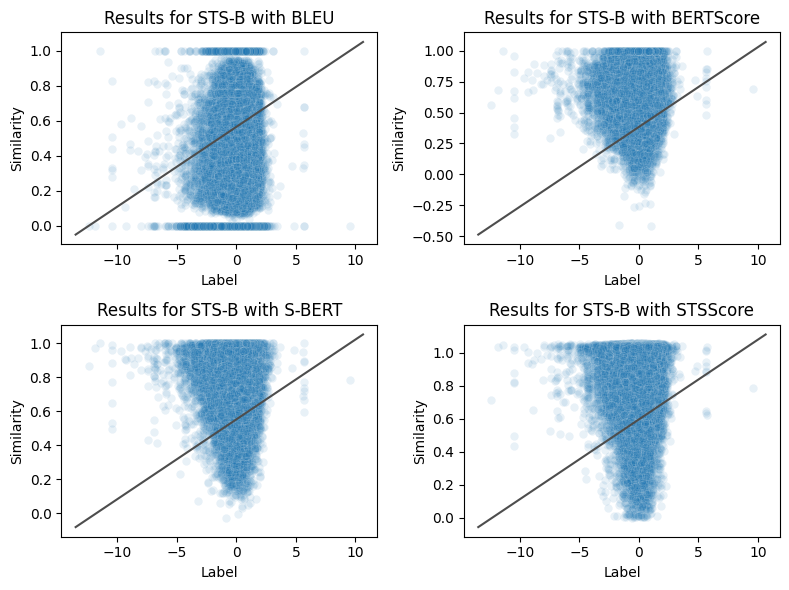

,label,bleu,bertscore_f1,sts_score,sbertcosine
label,1.000000,0.034179,0.033742,0.023123,0.022821
bleu,0.034179,1.000000,0.692705,0.449653,0.499502
bertscore_f1,0.033742,0.692705,1.000000,0.649779,0.655790
sts_score,0.023123,0.449653,0.649779,1.000000,0.777262
sbertcosine,0.022821,0.499502,0.655790,0.777262,1.000000


,label,bleu,bertscore_f1,sts_score,sbertcosine
label,1.000000,0.038288,0.036762,0.029268,0.029785
bleu,0.038288,1.000000,0.696515,0.493934,0.570700
bertscore_f1,0.036762,0.696515,1.000000,0.679031,0.699005
sts_score,0.029268,0.493934,0.679031,1.000000,0.762631
sbertcosine,0.029785,0.570700,0.699005,0.762631,1.000000


In [45]:
scores_wmt22 = pd.read_csv('scores/wmt22.csv')

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.scatterplot(x="label", y="bleu", data=scores_wmt22, alpha=0.1, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_wmt22, alpha=0.1, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_wmt22, alpha=0.1, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_wmt22, alpha=0.1, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/wmt22.pdf', bbox_inches='tight')
plt.show()

#print('Pearson correlation')
display(scores_wmt22[['label', 'bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']].corr(method='pearson'))
#print('Spearman correlation')
display(scores_wmt22[['label', 'bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']].corr(method='spearman'))